In [0]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

import math

import sys
import time

import numpy as np
import pandas as pd
import json
import collections
import logging
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt


pd.options.display.float_format = '{:.3f}'.format

In [0]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 5.0MB/s 


In [0]:
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering
from pytorch_pretrained_bert.tokenization import BasicTokenizer, BertTokenizer, whitespace_tokenize

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Hugging-Face's Script for Evaluating BERT on SQuAD

<a href="https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_squad.py">Github link to the script</a>

In [0]:
!mkdir hugging-face-squad
!echo > hugging-face-squad/__init__.py
!wget 'https://raw.githubusercontent.com/huggingface/pytorch-pretrained-BERT/master/examples/run_squad.py'
!mv run_squad.py hugging-face-squad/

--2019-05-20 18:09:15--  https://raw.githubusercontent.com/huggingface/pytorch-pretrained-BERT/master/examples/run_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50938 (50K) [text/plain]
Saving to: ‘run_squad.py’

run_squad.py        100%[===================>]  49.74K  --.-KB/s    in 0.01s   

2019-05-20 18:09:16 (3.39 MB/s) - ‘run_squad.py’ saved [50938/50938]



In [0]:
import importlib
hfs = importlib.import_module('.run_squad', package='hugging-face-squad')

# Download Dataset

In [0]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

--2019-05-20 18:09:18--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   214MB/s    in 0.2s    

2019-05-20 18:09:18 (214 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2019-05-20 18:09:19--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

## Store Dataset in a DataFrame and Print Some Samples

In [0]:
with open('dev-v2.0.json', 'r') as f:
    valid_data = json.load(f)['data']
print('Number of validation datapoints is ', len(valid_data))

Number of validation datapoints is  35


In [0]:
with open('train-v2.0.json', 'r') as f:
    train_data = json.load(f)['data']
print('Number of training datapoints is ', len(train_data))

Number of training datapoints is  442


In [0]:
def PrettyPrintSentence(sentence_, size_=15):
    word_list_ = sentence_.split()
    chunks_ = [' '.join(word_list_[x:x+size_]) for x \
               in range(0, len(word_list_), size_)]
    for c in chunks_:
        print(c) 
        
def PrettyPrintQA(qa_list):
    print('Question', ' '*90, 'Answer')
    for qdict in qa_list:
        ques_ = qdict['question']
        is_impossible = qdict['is_impossible']
        if not is_impossible:
            ans_ = qdict['answers'][0]['text']
        else:
            ans_ = '[PLAUSIBLE] ' + qdict['plausible_answers'][0]['text']
        print(ques_ + ' '*(100-len(ques_)) + ans_)

def PrintAttributeNames(obj_):
    attrs_ = dir(obj_)
    print('The attributes of object {} are:'.format(str(type(obj_)).\
                            replace('<class \'', '').replace('\'>', '')))
    for attr_ in attrs_:
        if '__' not in attr_:
            print(attr_)

In [0]:
idx_ = 1
sample_ = train_data[idx_]['paragraphs']
print('Example from the Training Set')

print('='*120)
print('CONTEXT: ')
print('='*120)
PrettyPrintSentence(sample_[0]['context'])
print('='*120)
print('Q&A: ')
print('='*120)
PrettyPrintQA(sample_[0]['qas'])

Example from the Training Set
CONTEXT: 
Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810
– 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by
citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who
wrote primarily for the solo piano. He gained and has maintained renown worldwide as one
of the leading musicians of his era, whose "poetic genius was based on a professional
technique that was without equal in his generation." Chopin was born in what was then
the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of
Congress Poland. A child prodigy, he completed his musical education and composed his earlier works
in Warsaw before leaving Poland at the age of 20, less than a month before
the outbreak of the November 1830 Uprising.
Q&A: 
Question                                                                                            Answ

In [0]:
idx_ = 0
sample_ = valid_data[idx_]['paragraphs']
print('Example from the Validation Set')

print('='*120)
print('CONTEXT: ')
print('='*120)
PrettyPrintSentence(sample_[0]['context'])
print('='*120)
print('Q&A: ')
print('='*120)
PrettyPrintQA(sample_[0]['qas'])

Example from the Validation Set
CONTEXT: 
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th
and 11th centuries gave their name to Normandy, a region in France. They were descended
from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who,
under their leader Rollo, agreed to swear fealty to King Charles III of West Francia.
Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants
would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic
identity of the Normans emerged initially in the first half of the 10th century, and
it continued to evolve over the succeeding centuries.
Q&A: 
Question                                                                                            Answer
In what country is Normandy located?                                                                Fr

# Data Preprocessing and Loading

In [0]:
BERT_TYPE = 'bert-base-uncased'
LOWER_CASE = True
PREDICT_BATCH_SIZE = 1
TRAIN_BATCH_SIZE = 8
MAX_SEQ_LEN = 384
DOC_STRIDE = 128
MAX_QUERY_LEN = 64

MAX_ANS_LEN = 30
N_BEST_SIZE = 20
NULL_SCORE_THRESHOLD = 0.0

### Below, valid_examples is a list of SquadExample objects.

In [0]:
valid_examples = hfs.read_squad_examples(input_file='dev-v2.0.json', \
                                         is_training=False, version_2_with_negative=True)

### The SquadExample object
Each instance of SquadExample represents one question. Its attributes are:
* doc_tokens is a list of tokens appearing in a Context string.
* question_text contains a single string which represents a question.
* qas_id
* other attributes are empty for Validation Set.

In [0]:
PrintAttributeNames(valid_examples[0])

The attributes of object hugging-face-squad.run_squad.SquadExample are:
doc_tokens
end_position
is_impossible
orig_answer_text
qas_id
question_text
start_position


In [0]:
tokenizer = BertTokenizer.from_pretrained(BERT_TYPE, do_lower_case=LOWER_CASE)

100%|██████████| 231508/231508 [00:00<00:00, 1182271.47B/s]


### The 'tokenizer' object contains two tokenizers
* basic_tokenizer
* wordpiece_tokenizer

In [0]:
PrintAttributeNames(tokenizer)

The attributes of object pytorch_pretrained_bert.tokenization.BertTokenizer are:
basic_tokenizer
convert_ids_to_tokens
convert_tokens_to_ids
do_basic_tokenize
from_pretrained
ids_to_tokens
max_len
save_vocabulary
tokenize
vocab
wordpiece_tokenizer


In [0]:
PrintAttributeNames(tokenizer.basic_tokenizer)

The attributes of object pytorch_pretrained_bert.tokenization.BasicTokenizer are:
_clean_text
_is_chinese_char
_run_split_on_punc
_run_strip_accents
_tokenize_chinese_chars
do_lower_case
never_split
tokenize


In [0]:
PrintAttributeNames(tokenizer.wordpiece_tokenizer)

The attributes of object pytorch_pretrained_bert.tokenization.WordpieceTokenizer are:
max_input_chars_per_word
tokenize
unk_token
vocab


### Below, valid_features is a list of InputFeatures objects.

In [0]:
valid_features = hfs.convert_examples_to_features(
            examples=valid_examples,
            tokenizer=tokenizer,
            max_seq_length=MAX_SEQ_LEN,
            doc_stride=DOC_STRIDE,
            max_query_length=MAX_QUERY_LEN,
            is_training=False)

In [0]:
PrintAttributeNames(valid_features[0])

The attributes of object hugging-face-squad.run_squad.InputFeatures are:
doc_span_index
end_position
example_index
input_ids
input_mask
is_impossible
segment_ids
start_position
token_is_max_context
token_to_orig_map
tokens
unique_id


### Below is a comparison of valid_features and valid_examples
* input_ids: Length is 384, which is a hyperparameter denoting max_sequence_length. All entries in input_ids after the index 166 are zeros and reflect padding.
* input_mask: Length is 384. Equals 1 where input_ids is non-zero. This mask takes care of padding.
* segment_ids: Length is 384. Equals 1 at indices where tokens DOES NOT contain a question or pad token. This mask preserves the context tokens.

At Test time, the inputs to the model are: input_ids, input_mask, segment_ids

In [0]:
print('='*150)
print('valid_examples')
print('='*150)
print('1. doc_tokens', ' '*7, '[Length: {}]'.format(len(valid_examples[0].doc_tokens)))
print(valid_examples[0].doc_tokens)
print('\n2. question_text', ' '*4, '[Length: {}]'.format(len(valid_examples[0].question_text)))
print(valid_examples[0].question_text)

print('\n')
print('='*150)
print('valid_features')
print('='*150)
print('1. tokens', ' '*11, '[Length: {}]'.format(len(valid_features[0].tokens)))
print(valid_features[0].tokens)
print('\n2. input_ids', ' '*8, '[Length: {}]'.format(len(valid_features[0].input_ids)))
print(valid_features[0].input_ids)

valid_examples
1. doc_tokens         [Length: 113]
['The', 'Normans', '(Norman:', 'Nourmands;', 'French:', 'Normands;', 'Latin:', 'Normanni)', 'were', 'the', 'people', 'who', 'in', 'the', '10th', 'and', '11th', 'centuries', 'gave', 'their', 'name', 'to', 'Normandy,', 'a', 'region', 'in', 'France.', 'They', 'were', 'descended', 'from', 'Norse', '("Norman"', 'comes', 'from', '"Norseman")', 'raiders', 'and', 'pirates', 'from', 'Denmark,', 'Iceland', 'and', 'Norway', 'who,', 'under', 'their', 'leader', 'Rollo,', 'agreed', 'to', 'swear', 'fealty', 'to', 'King', 'Charles', 'III', 'of', 'West', 'Francia.', 'Through', 'generations', 'of', 'assimilation', 'and', 'mixing', 'with', 'the', 'native', 'Frankish', 'and', 'Roman-Gaulish', 'populations,', 'their', 'descendants', 'would', 'gradually', 'merge', 'with', 'the', 'Carolingian-based', 'cultures', 'of', 'West', 'Francia.', 'The', 'distinct', 'cultural', 'and', 'ethnic', 'identity', 'of', 'the', 'Normans', 'emerged', 'initially', 'in', 'the', '

# Model Setup


## Download BERT model weights finetuned for SQuAD by me
### DISCLAIMER: Use at your own risk
I will not be held responsbile for any loss of any sort occuring to you from use of these finetuned weights.

In [0]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1nDs0_agVNDsn5X_b0QCKNQVIQ-aGBFzY
!unzip -qq squad.zip 

Downloading...
From: https://drive.google.com/uc?id=1nDs0_agVNDsn5X_b0QCKNQVIQ-aGBFzY
To: /content/squad.zip
405MB [00:03, 124MB/s]


In [0]:
model_state_dict = torch.load('checkpoints/pytorch_model.bin')
model = BertForQuestionAnswering.from_pretrained(BERT_TYPE, state_dict=model_state_dict)
model.to(device);

# Evaluation on Validation Set Samples

In [0]:
model.eval();

In [0]:
all_input_ids = torch.tensor([f.input_ids for f in valid_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in valid_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in valid_features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
valid_data_tensor = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)
# Run prediction for full data
valid_sampler = SequentialSampler(valid_data_tensor)
valid_dataloader = DataLoader(valid_data_tensor, sampler=valid_sampler, batch_size=PREDICT_BATCH_SIZE)


In [0]:
input_ids, input_mask, segment_ids, example_indices = next(iter(valid_dataloader))
input_ids = input_ids.to(device)
input_mask = input_mask.to(device)
segment_ids = segment_ids.to(device)
with torch.no_grad():
    batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)

In [0]:
all_examples = []
all_features = []
all_results = []
for i, example_index in enumerate(example_indices):
    start_logits = batch_start_logits[i].detach().cpu().tolist()
    end_logits = batch_end_logits[i].detach().cpu().tolist()
    valid_feature = valid_features[example_index.item()]
    unique_id = int(valid_feature.unique_id)
    all_results.append(hfs.RawResult(unique_id=unique_id,
                                 start_logits=start_logits,
                                 end_logits=end_logits))
    all_examples.append(valid_examples[example_index.item()])
    all_features.append(valid_feature)

In [0]:
PRED_FILE = 'predictions.json'
N_BEST_FILE = 'nbest.json'
LOG_ODDS_FILE = 'logodds.json'

In [0]:
hfs.write_predictions(all_examples=all_examples, 
                      all_features=all_features, 
                      all_results=all_results,
                      n_best_size=N_BEST_SIZE, 
                      max_answer_length=MAX_ANS_LEN,
                      do_lower_case=LOWER_CASE, 
                      output_prediction_file=PRED_FILE,
                      output_nbest_file=N_BEST_FILE, 
                      output_null_log_odds_file=LOG_ODDS_FILE, 
                      verbose_logging=True,
                      version_2_with_negative=True, 
                      null_score_diff_threshold=NULL_SCORE_THRESHOLD)

In [0]:
results_json = pd.read_json('nbest.json')
results_text = [results_json.iloc[i].values[0]['text'] for i in range(len(results_json))]
results_prob = [results_json.iloc[i].values[0]['probability'] for i in range(len(results_json))]
df = pd.DataFrame({'Probability' : results_prob,
                   'Text' : results_text
                  })

In [0]:
df.head()

,Probability,Text
0,0.999,France
1,0.001,France.
2,0.000,"Normandy, a region in France"
3,0.000,in France
4,0.000,a region in France


# Evaluation on Custom Examples

In [0]:
def GetQuestionDict(context_, question_):
    main_dict = {'title' : 'test-question',
            'paragraphs' : []}
    para_dict = {'context' : context_,
            'qas' : []}
       
    ques_dict = {'answers' : [],
                'id' : i+1,
                'is_impossible' : False,
                'question' : question_}

    para_dict['qas'].append(ques_dict)
    main_dict['paragraphs'].append(para_dict)
    return_dict = {'data' : [main_dict],
                  'version' : 'no-cares'}
    
    return return_dict

def GetFeatures(context_, question_):
    input_ = GetQuestionDict(context_, question_)

    import json
    with open('test.json', 'w') as f:
        json.dump(input_, f)
        
    test_examples = hfs.read_squad_examples(input_file='test.json', \
                   is_training=False, version_2_with_negative=True)
    test_features = hfs.convert_examples_to_features(
            examples=test_examples,
            tokenizer=tokenizer,
            max_seq_length=MAX_SEQ_LEN,
            doc_stride=DOC_STRIDE,
            max_query_length=MAX_QUERY_LEN,
            is_training=False)
    
    return test_examples, test_features

def GetPrediction(model, context_, question_):
    test_examples, test_features = GetFeatures(context_, question_)
    
    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
    all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
    test_data_tensor = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)
    # Run prediction for full data
    test_sampler = SequentialSampler(test_data_tensor)
    test_dataloader = DataLoader(test_data_tensor, sampler=test_sampler, batch_size=PREDICT_BATCH_SIZE)

    input_ids, input_mask, segment_ids, example_indices = next(iter(test_dataloader))
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    with torch.no_grad():
        batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)
    
    all_examples = []
    all_features = []
    all_results = []
    for i, example_index in enumerate(example_indices):
        start_logits = batch_start_logits[i].detach().cpu().tolist()
        end_logits = batch_end_logits[i].detach().cpu().tolist()
        test_feature = test_features[example_index.item()]
        unique_id = int(test_feature.unique_id)
        all_results.append(hfs.RawResult(unique_id=unique_id,
                                     start_logits=start_logits,
                                     end_logits=end_logits))
        all_examples.append(test_examples[example_index.item()])
        all_features.append(test_feature)
        
    PRED_FILE = 'test-predictions.json'
    N_BEST_FILE = 'test-nbest.json'
    LOG_ODDS_FILE = 'test-logodds.json'

    hfs.write_predictions(all_examples=all_examples, 
                          all_features=all_features, 
                          all_results=all_results,
                          n_best_size=N_BEST_SIZE, 
                          max_answer_length=MAX_ANS_LEN,
                          do_lower_case=LOWER_CASE, 
                          output_prediction_file=PRED_FILE,
                          output_nbest_file=N_BEST_FILE, 
                          output_null_log_odds_file=LOG_ODDS_FILE, 
                          verbose_logging=True,
                          version_2_with_negative=True, 
                          null_score_diff_threshold=NULL_SCORE_THRESHOLD)

    results_json = pd.read_json('test-nbest.json')
    results_text = [results_json.iloc[i].values[0]['text'] for i in range(len(results_json))]
    results_prob = [results_json.iloc[i].values[0]['probability'] for i in range(len(results_json))]
    df = pd.DataFrame({'Probability' : results_prob,
                       'Text' : results_text
                      })
    return df

# Visualization

In [0]:
idx_ = 0
context_ = valid_data[idx_]['paragraphs'][0]['context']
PrettyPrintSentence(context_)

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th
and 11th centuries gave their name to Normandy, a region in France. They were descended
from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who,
under their leader Rollo, agreed to swear fealty to King Charles III of West Francia.
Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants
would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic
identity of the Normans emerged initially in the first half of the 10th century, and
it continued to evolve over the succeeding centuries.


In [0]:
def GetActivation(model, context_, question_):
    name_list = ['key', 'query']
    NUM_LAYERS = 12
    activation = {i : {name_ : [] for name_ in name_list} \
                  for i in range(NUM_LAYERS)}
    
    def GetHook(layer_, name_):
        def hook(model, input_, output_):
            activation[layer_][name_].append(output_.detach())
        return hook
    for i in range(NUM_LAYERS):
        model.bert.encoder.layer[i].attention.self.key.register_forward_hook(
                                                GetHook(i, 'key'))
        model.bert.encoder.layer[i].attention.self.query.register_forward_hook(
                                                GetHook(i, 'query'))
    df  = GetPrediction(model, context_, question_)
    return df, activation

In [0]:
question_ = 'In what country is Normandy located?'
df, activation = GetActivation(model, context_, question_)

In [0]:
def PlotAttention(activation, layer_):
    keys_ = activation[layer_]['key'][0].cpu().numpy()[0,...]
    queries_ = activation[layer_]['query'][0].cpu().numpy()[0,...]
    d_k = keys_.shape[-1]
    attention_ = softmax(np.matmul(queries_, keys_.T)/np.sqrt(d_k), axis=1)
    examples_, features_ = GetFeatures(context_, question_)

    ques_start = 1
    ques_end = features_[0].tokens.index('[SEP]') - 1
    ques_tokens = features_[0].tokens[ques_start:ques_end+1]

    NUM_COLS = 50
    NUM_SUBPLOTS = int(np.ceil(len(features_[0].tokens)/NUM_COLS))
    fig, ax = plt.subplots(NUM_SUBPLOTS, 1)
    for i in range(NUM_SUBPLOTS):
        attention_ques_on_context = attention_[ques_start:ques_end+1,
                                              i*NUM_COLS:min(len(features_[0].tokens), 
                                                             (i+1)*NUM_COLS)]

        if attention_ques_on_context.shape[1] < NUM_COLS:
            attention_ques_on_context = np.hstack([attention_ques_on_context,
                                                  np.zeros((attention_ques_on_context.shape[0],
                                                   NUM_COLS - attention_ques_on_context.shape[1]))])

        context_tokens = features_[0].tokens[i*NUM_COLS:(i+1)*NUM_COLS]

        sns.heatmap(data=attention_ques_on_context, 
                    ax=ax[i], 
                    cmap="YlGnBu", 
                    cbar=False,
                    xticklabels=context_tokens,
                    yticklabels=ques_tokens,
                    vmin=0.0, vmax=1.0)
        ax[i].yaxis.set_tick_params(labelsize=12)
        ax[i].xaxis.set_tick_params(labelsize=9, 
                                    labeltop=True, 
                                    bottom=False, 
                                    labelbottom=False,
                                    labelrotation=90)
    fig.set_size_inches(15, 17)
    fig.set_facecolor('w')
    fig.suptitle('Layer {}'.format(layer_), fontweight='bold', fontsize=12)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(hspace=0.3)
    fig.savefig('Layer{}.png'.format(layer_),
               dpi=300,
               bbox_inches='tight')

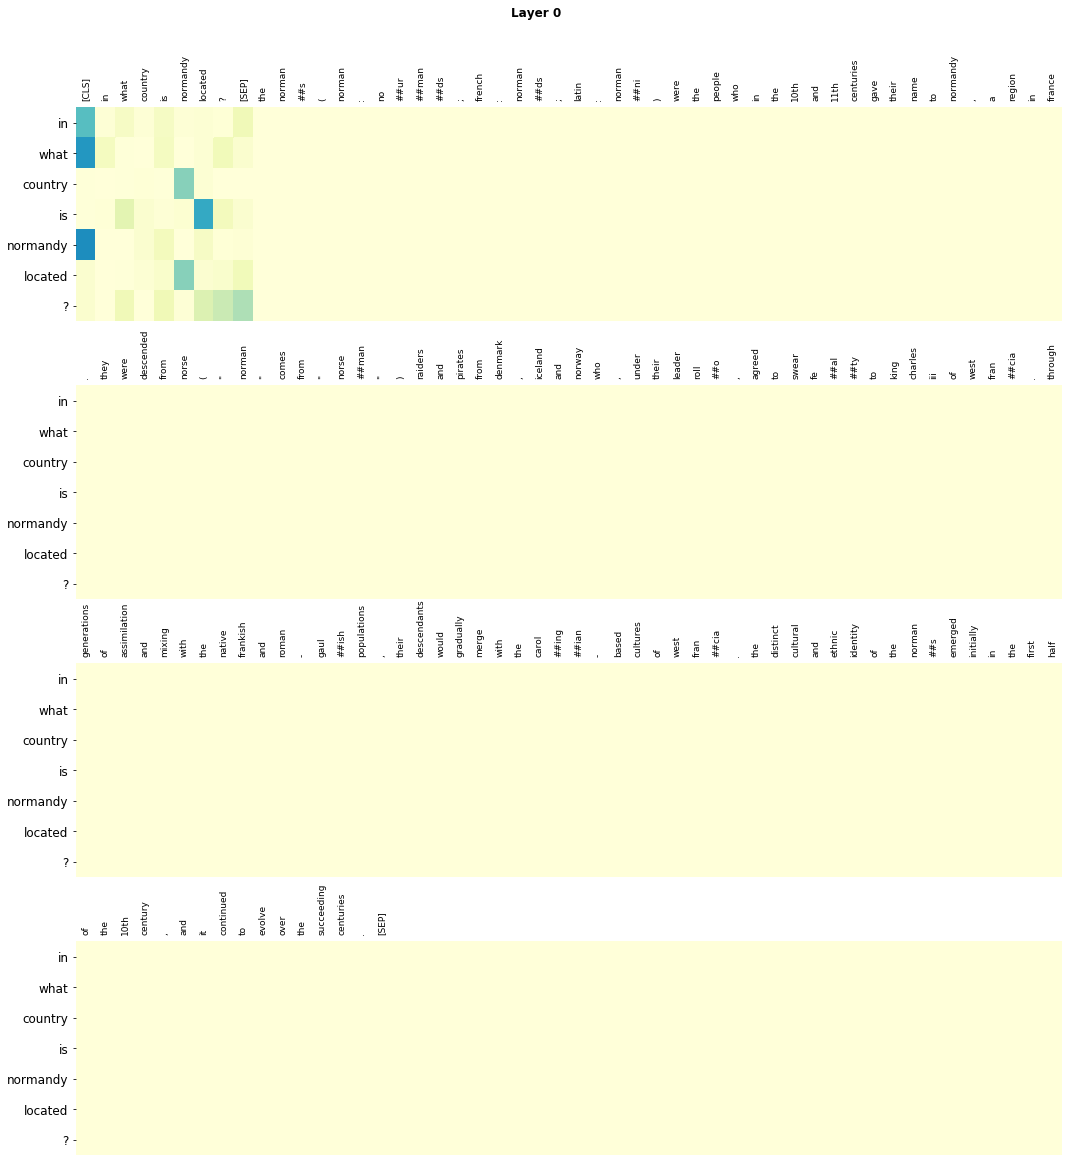

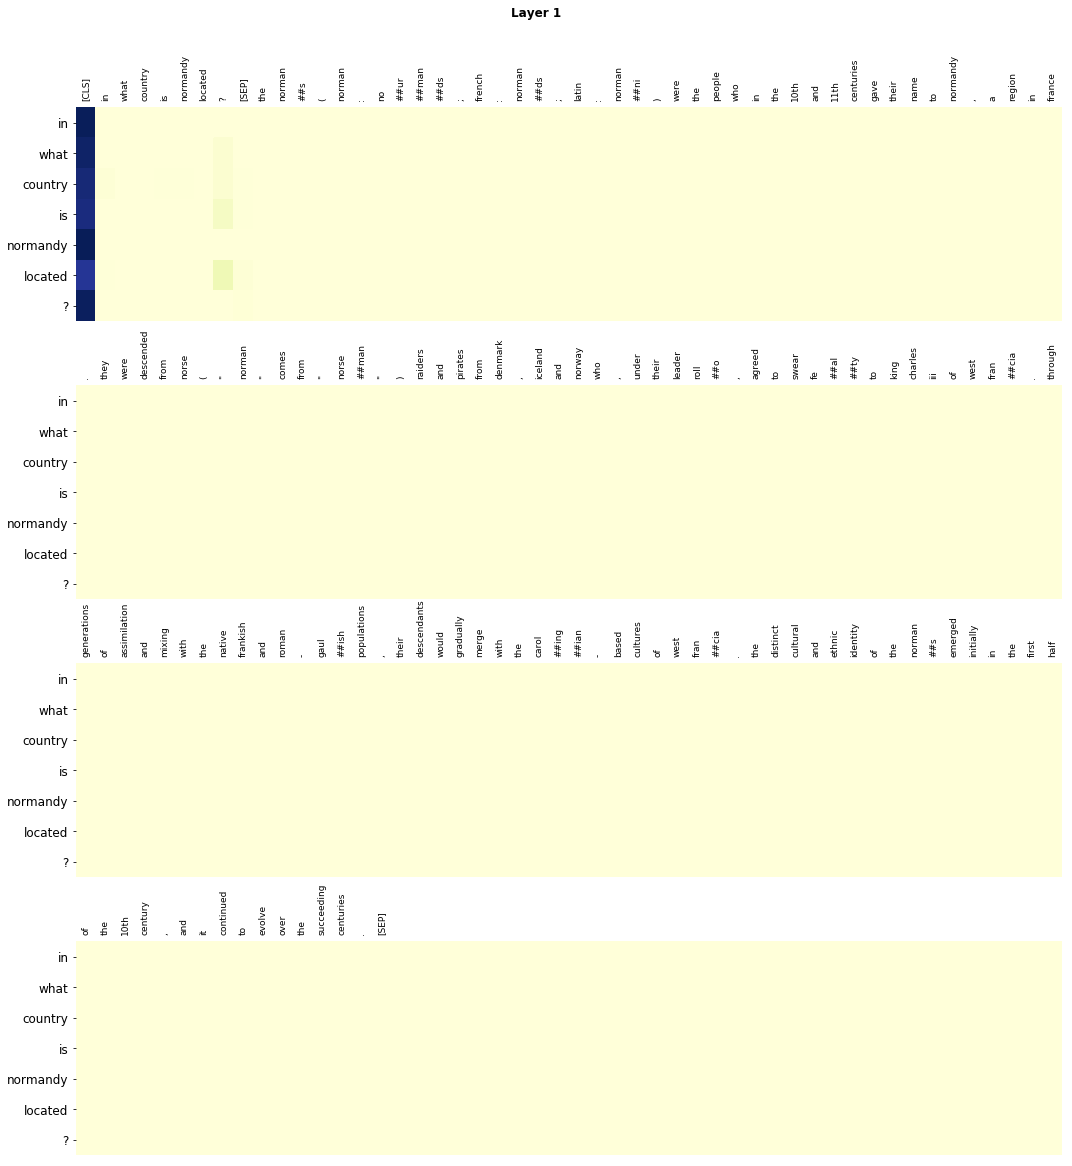

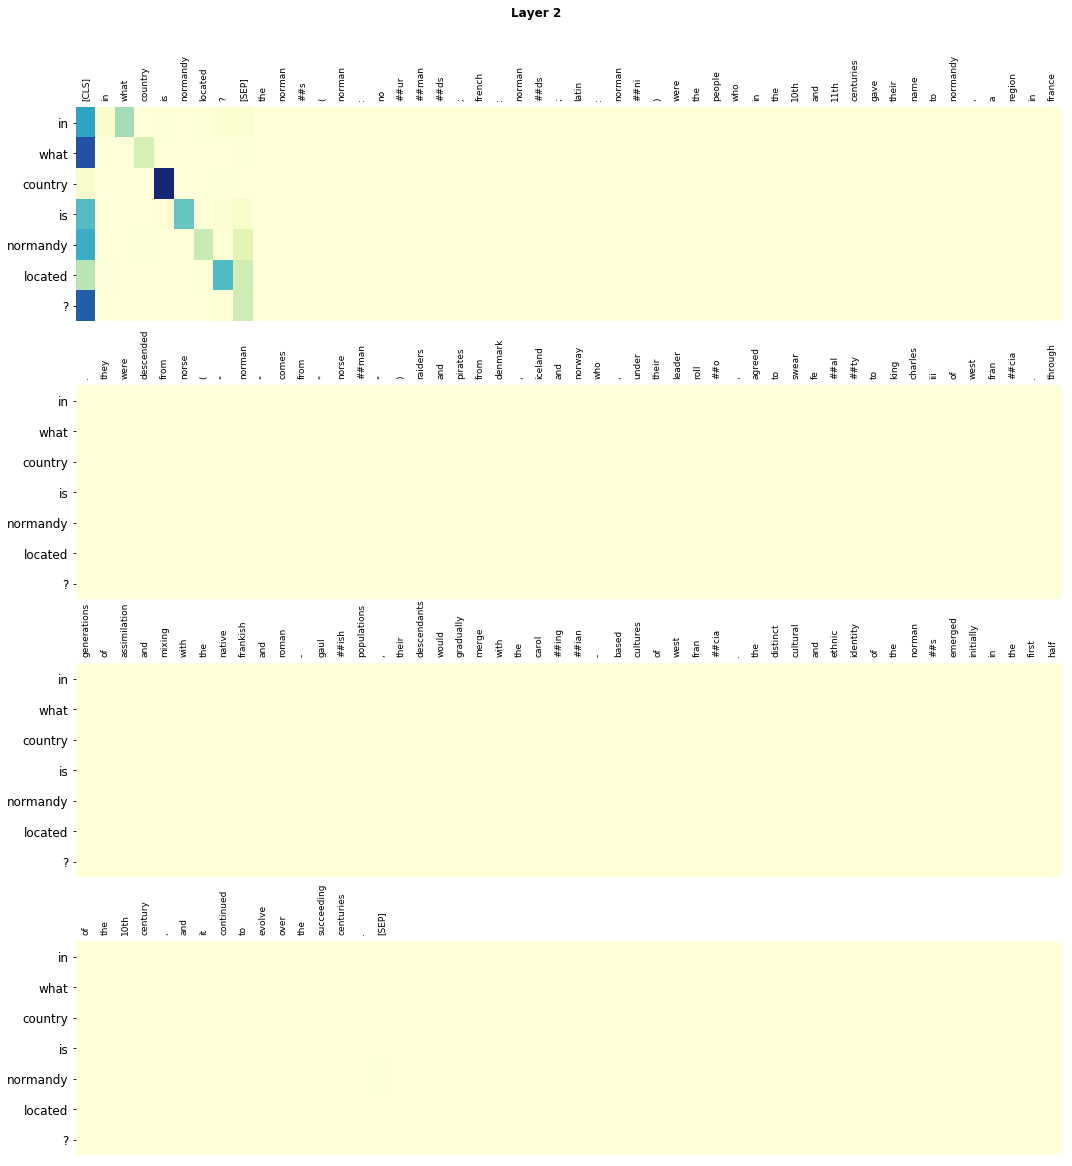

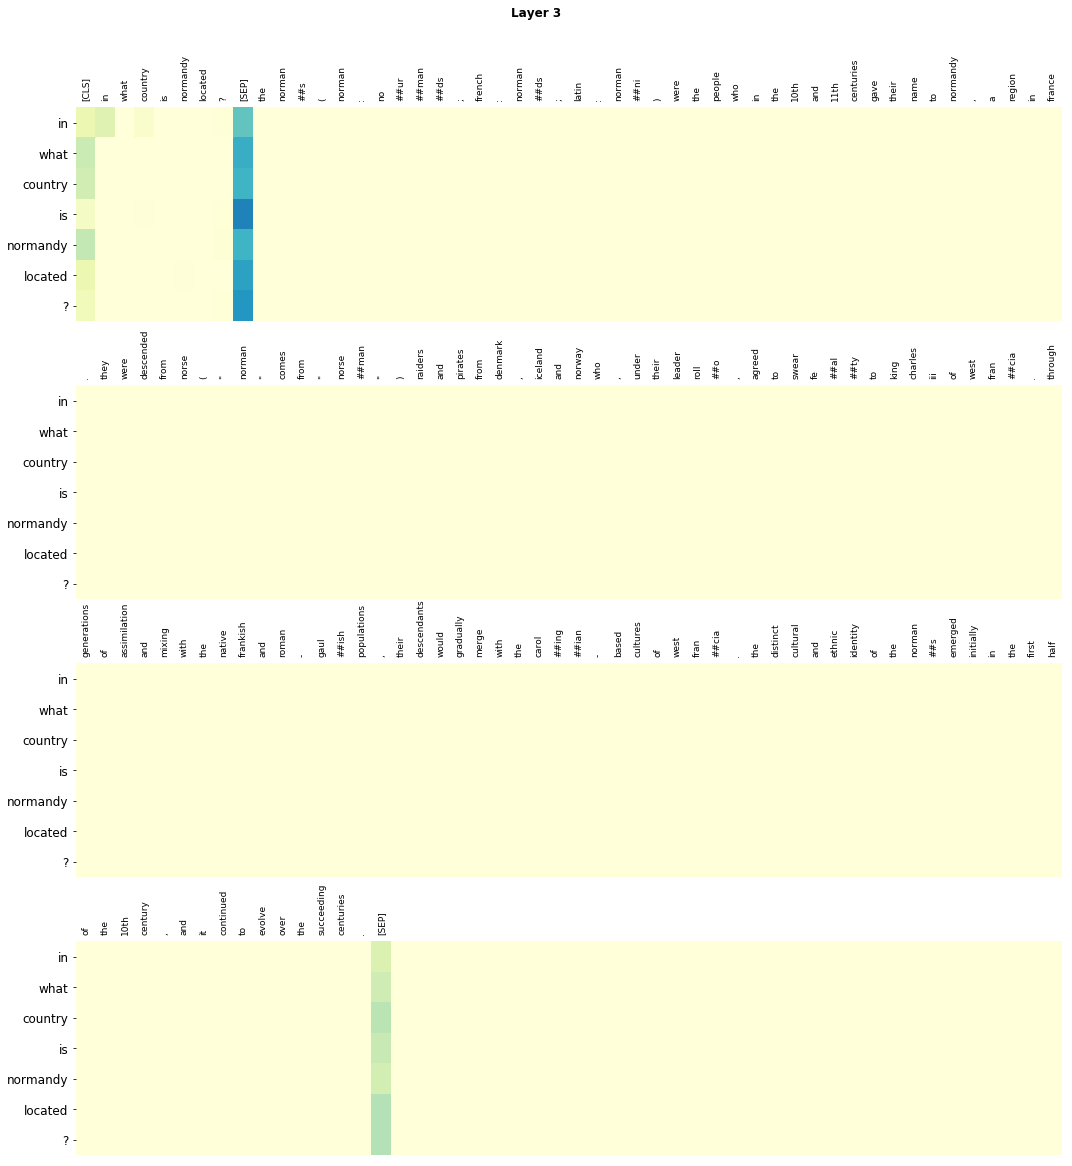

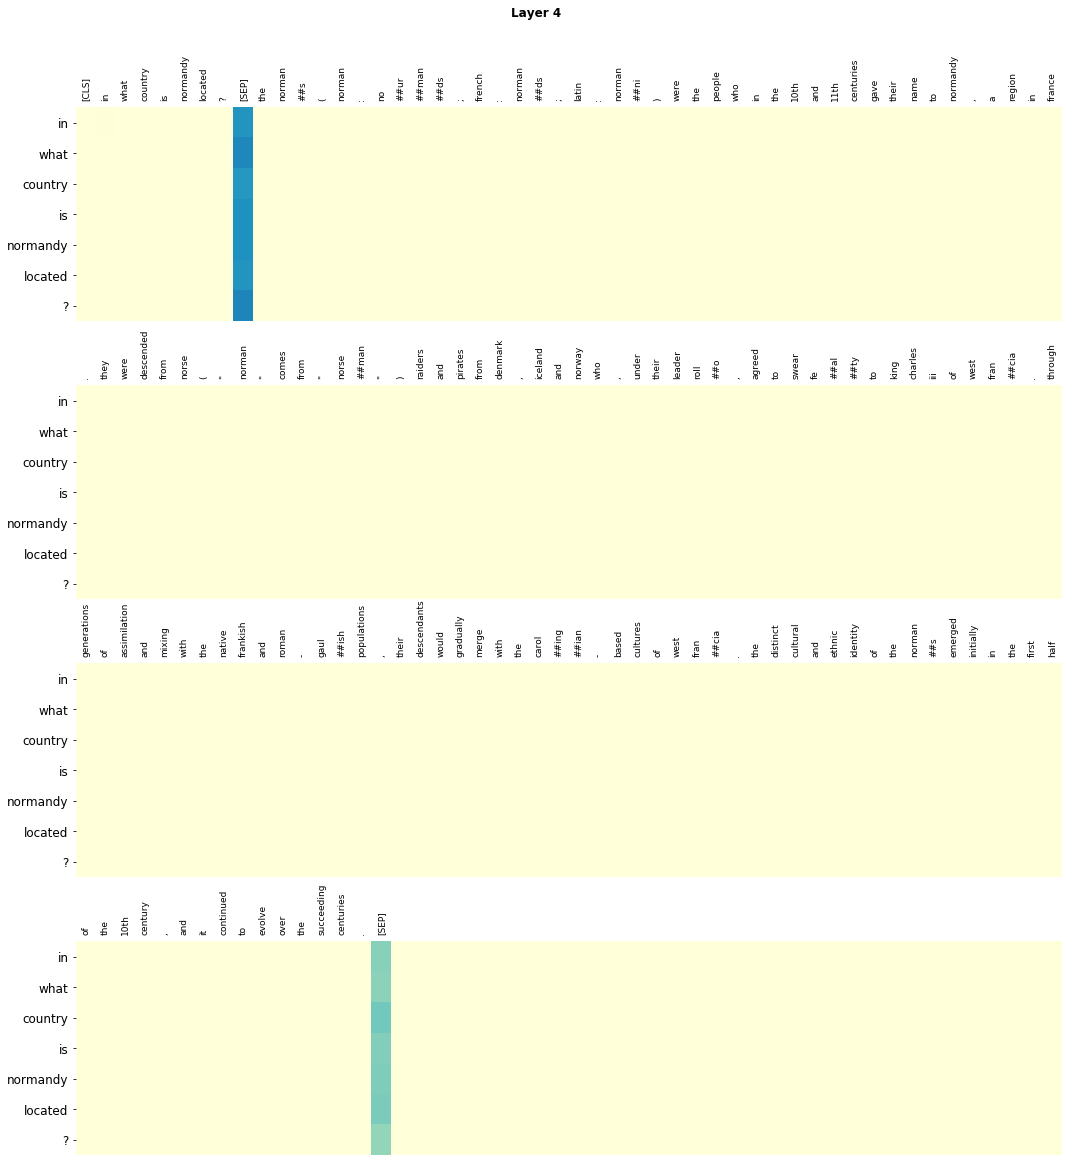

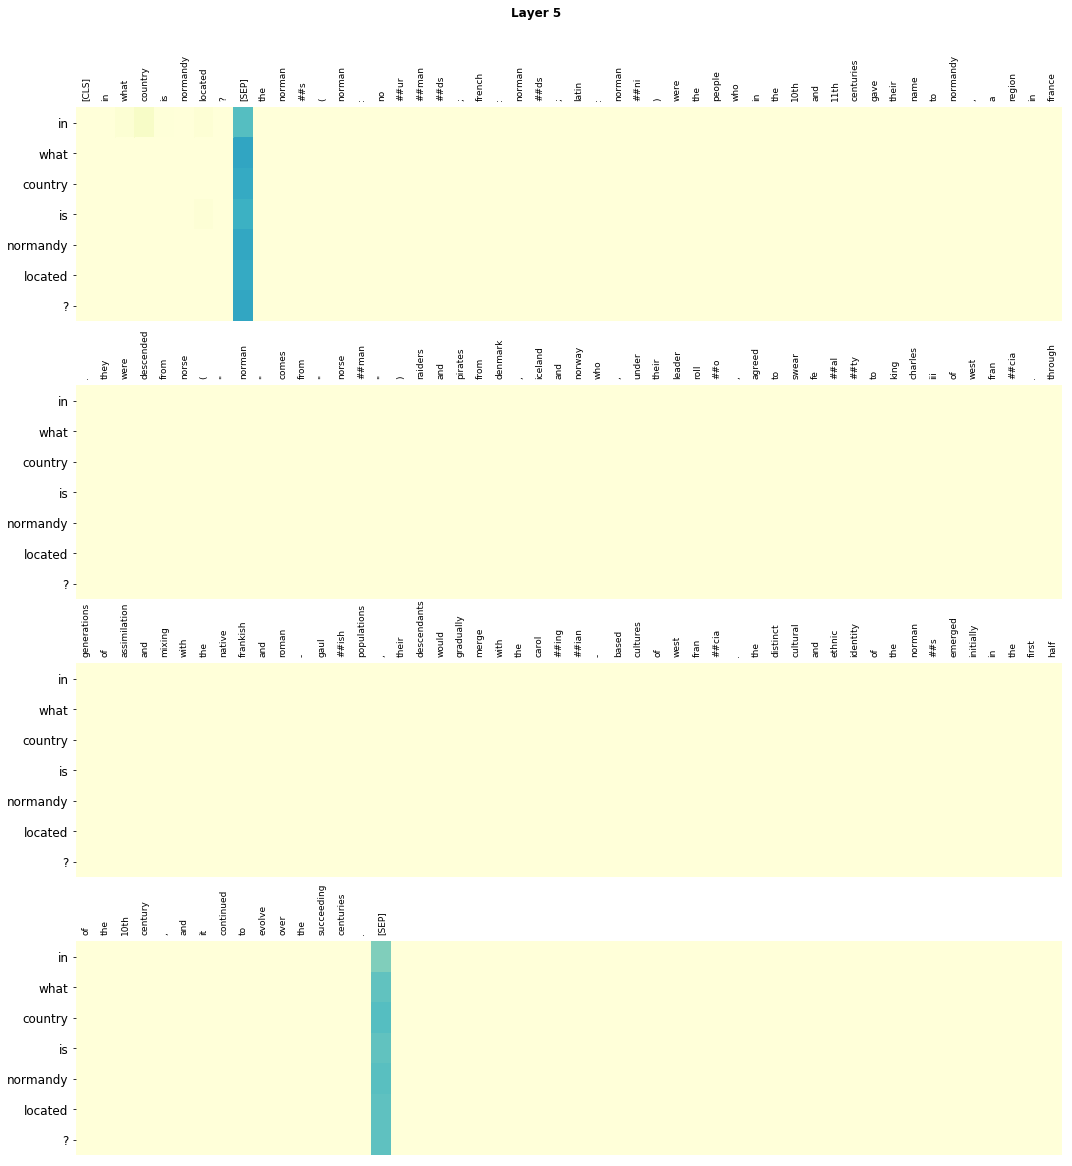

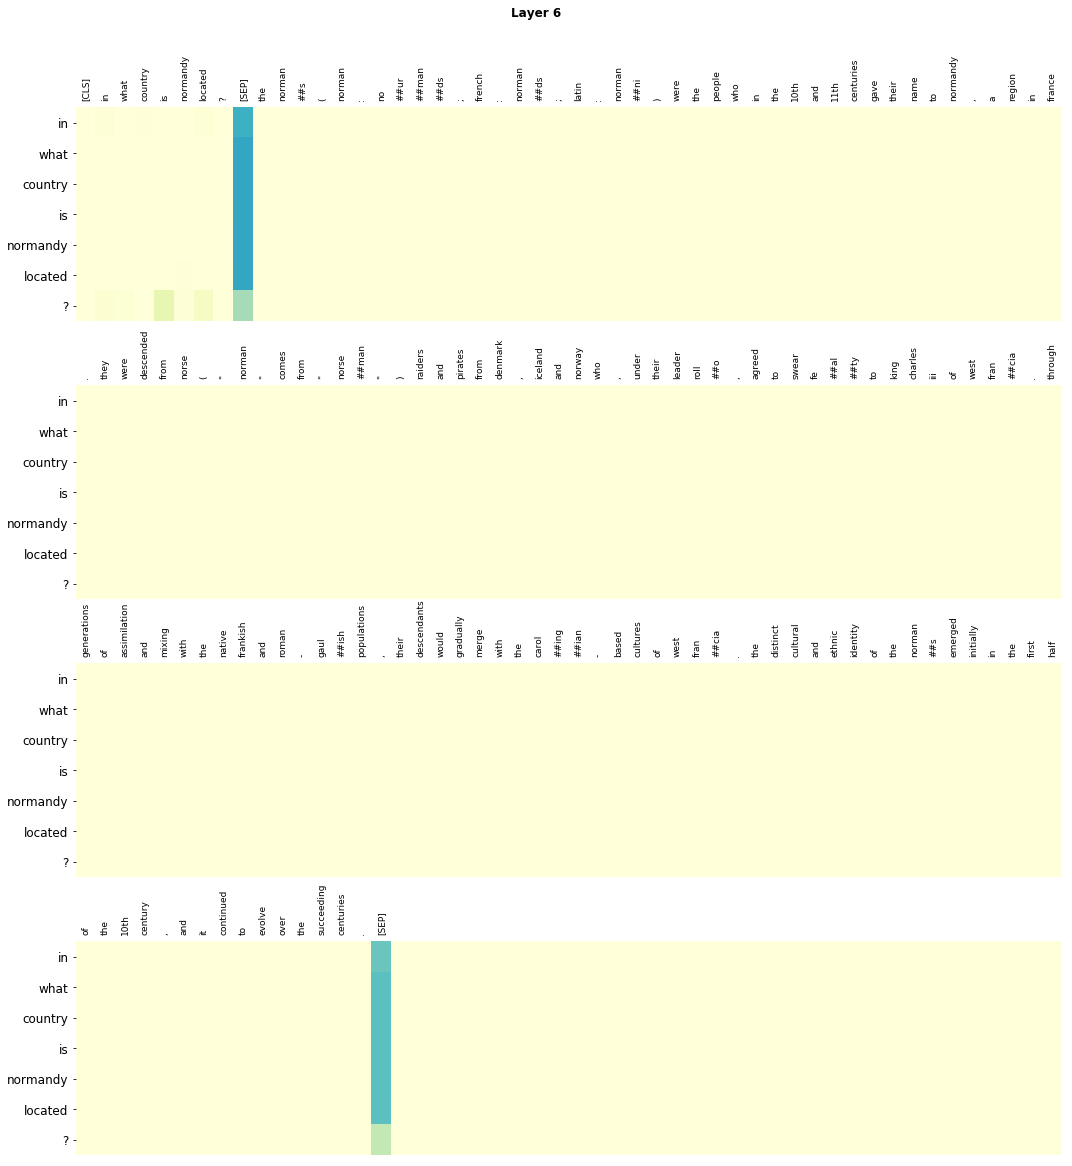

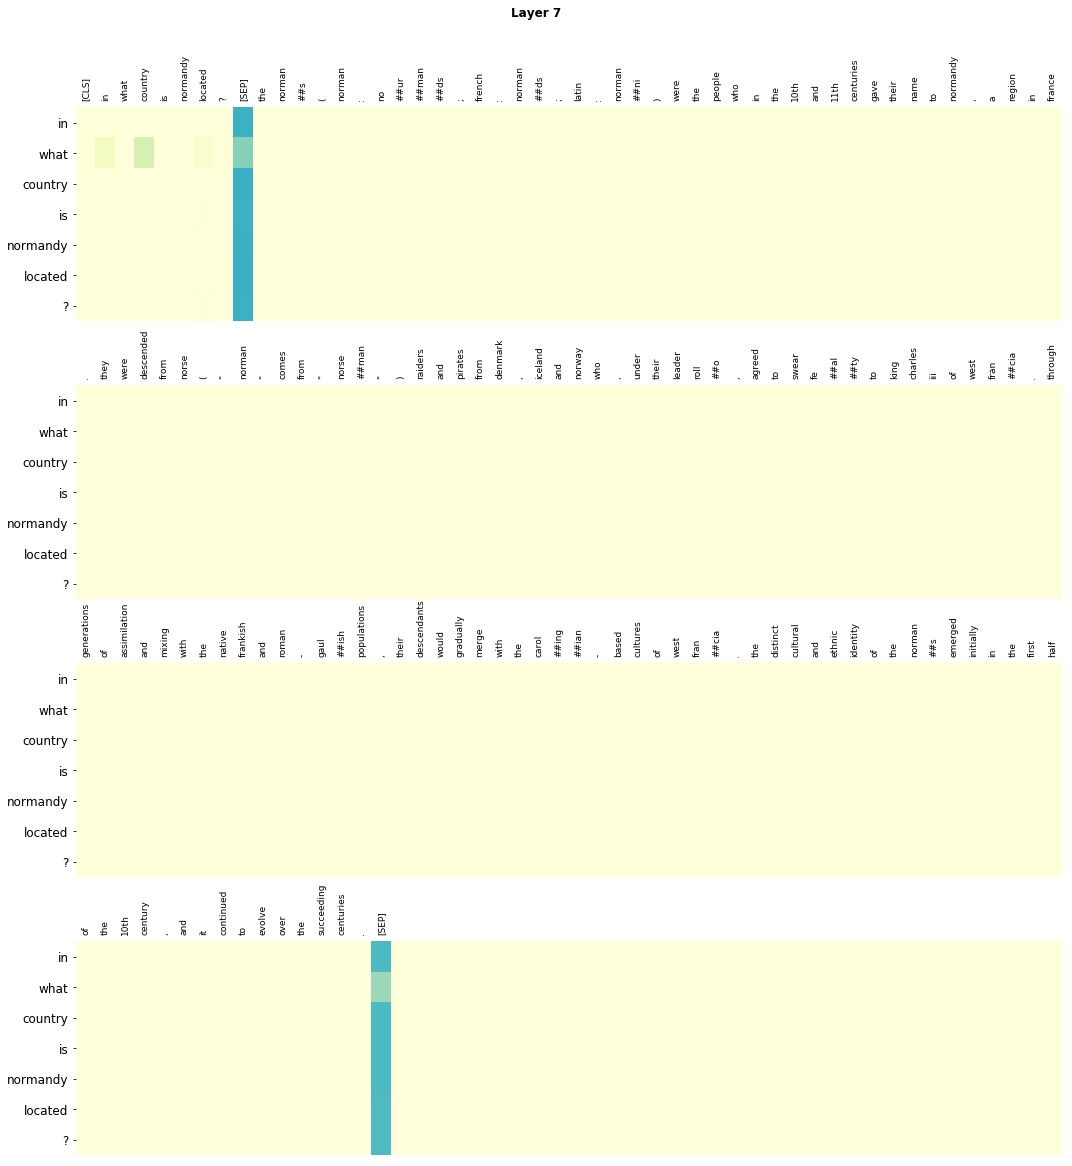

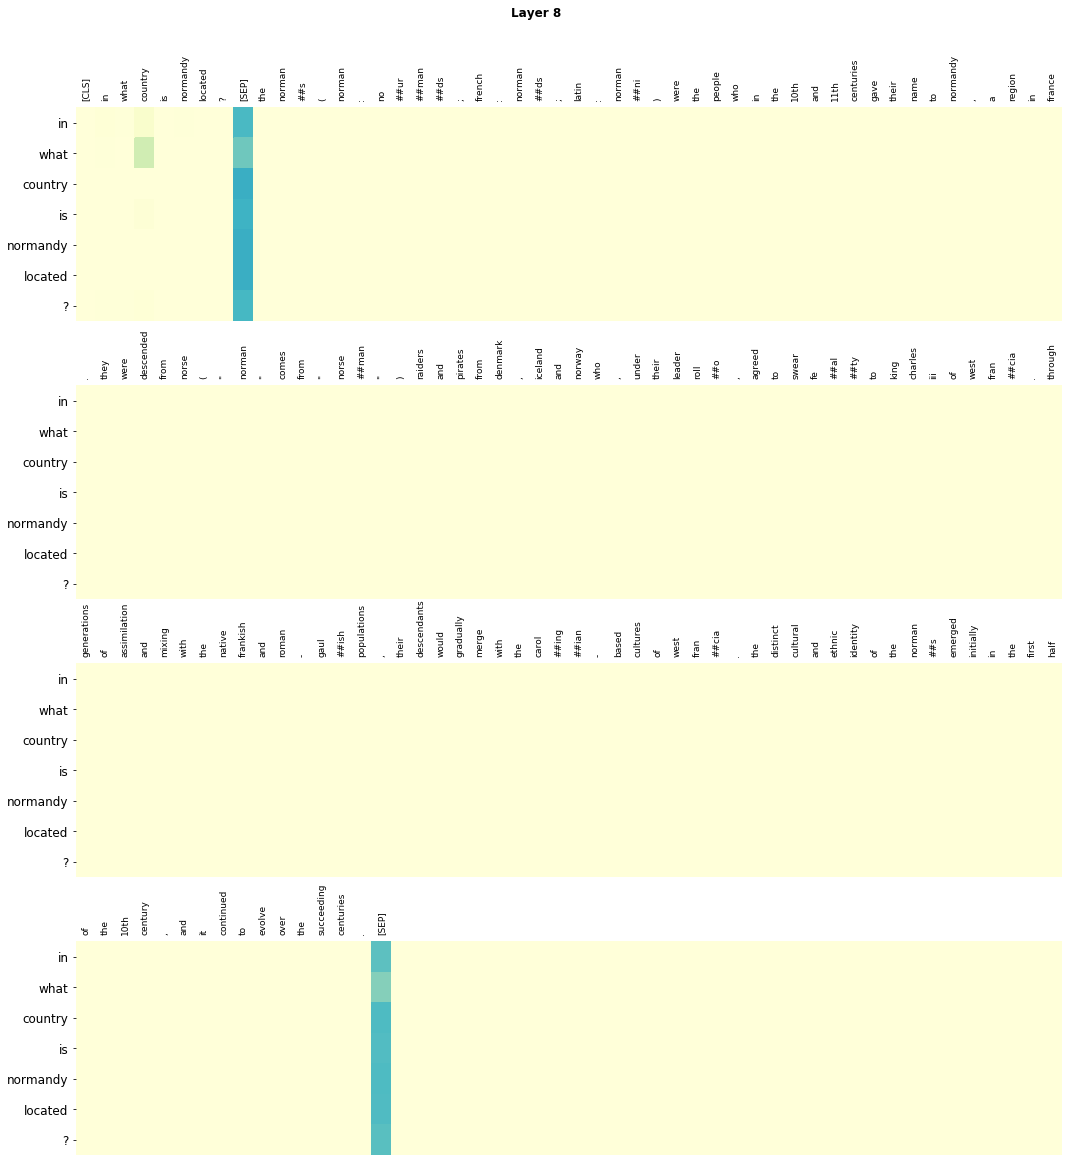

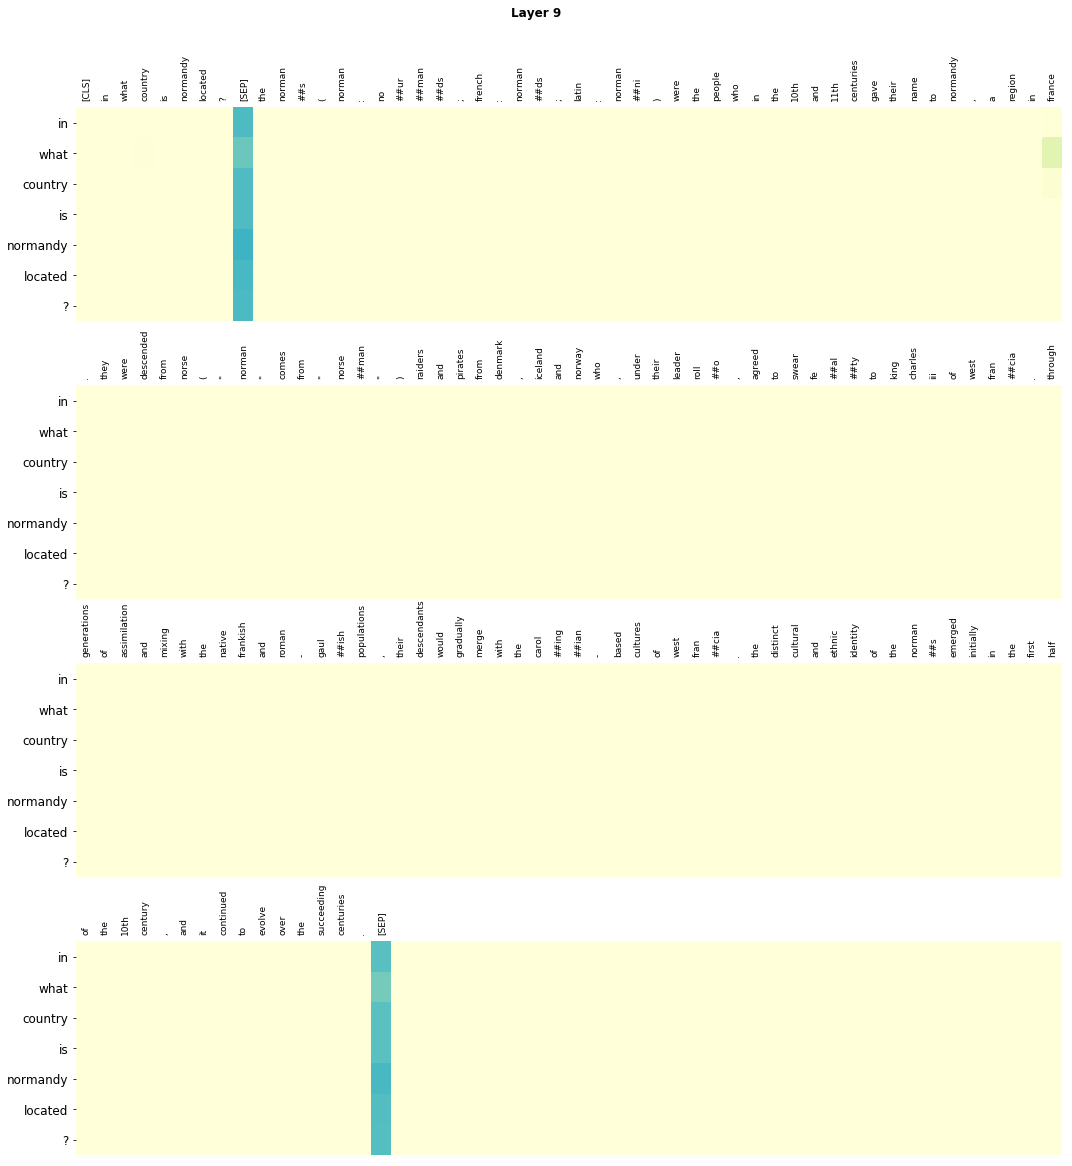

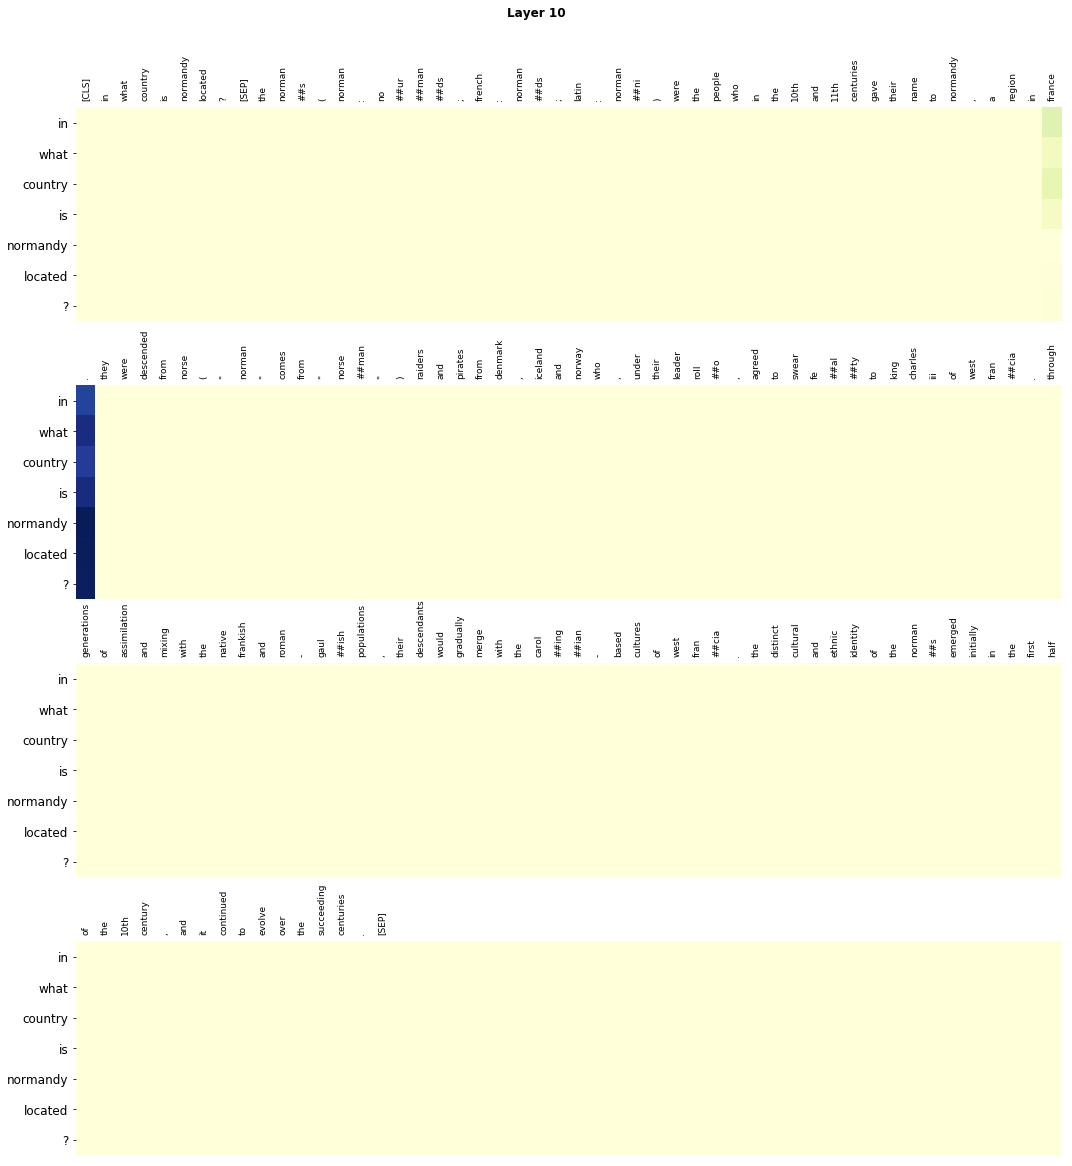

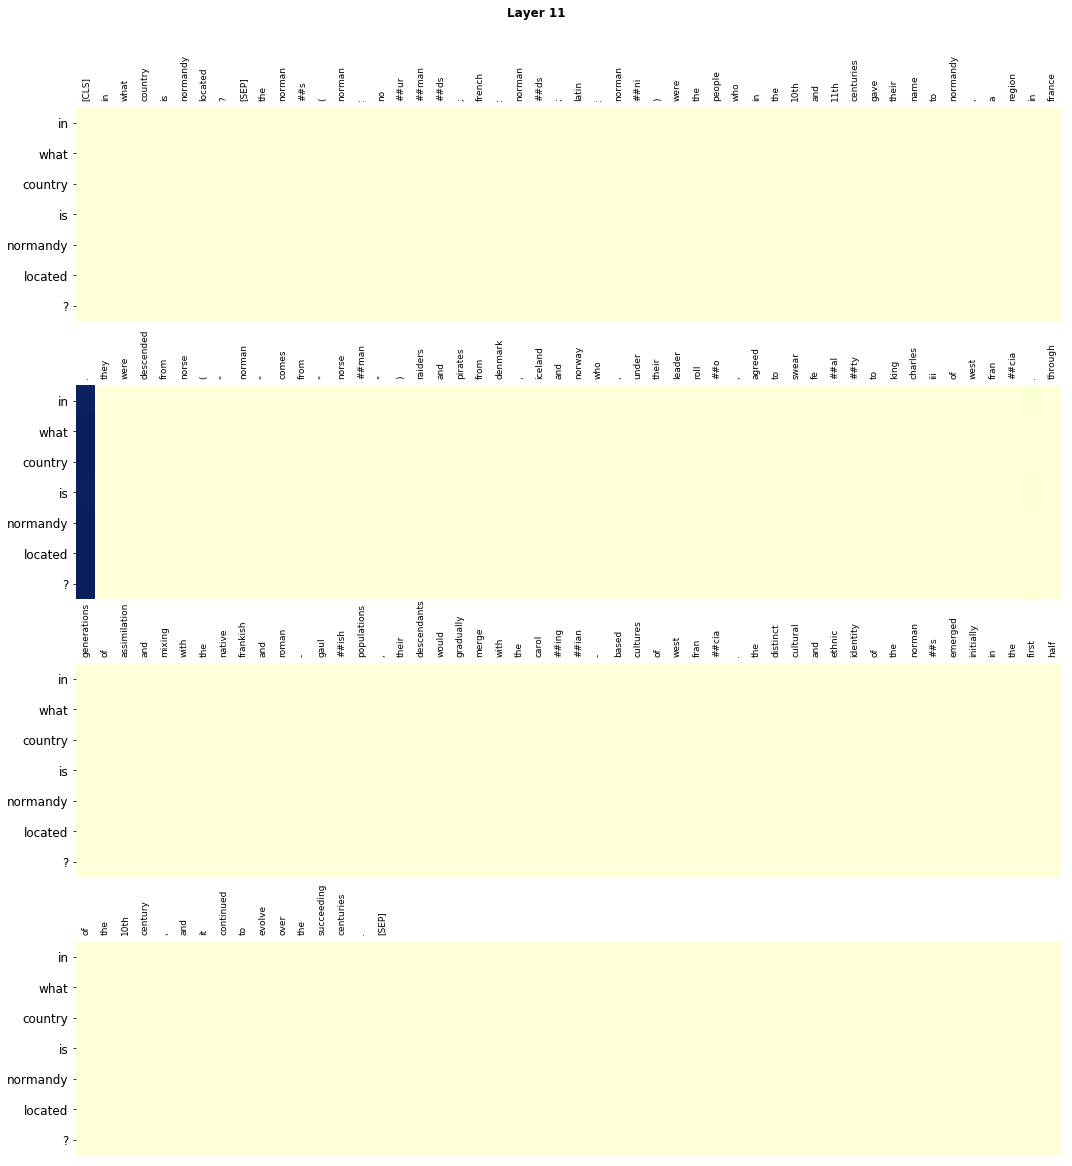

In [0]:
for i in range(12):
    PlotAttention(activation, layer_=i);

In [0]:
print('Question: ', question_)
df.head()

Question:  In what country is Normandy located?


,Probability,Text
0,0.999,France
1,0.001,France.
2,0.000,"Normandy, a region in France"
3,0.000,in France
4,0.000,a region in France
